In [1]:
caffe_root = '/home/ubuntu/caffe2/caffe/' 
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
import numpy as np
import pandas as pd
from pylab import *
%matplotlib inline
import tempfile
import os
import time

In [4]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [3]:
def make_output_df(output_filepath = None):
    if (output_filepath == None):
        output_filepath = '/home/ubuntu/distracteddriver/data/imgs/output1.txt'
    df = pd.read_csv(output_filepath, delimiter= ' ', header =None, names = ['filepath', 'fake_label'])
    return df

In [14]:
def get_output_array(df, batch_size = 10):
    max_iter = df.shape[0] -1
    batch_size = 20
    output = np.zeros((0,10))
    
    start_time = time.time()
    
    for i in range(0,max_iter, batch_size):
        for j in range(0,batch_size):
            input_image = caffe.io.load_image(df.filepath.iloc[i+j])
            outputnet.blobs['data'].data[j,...] = transformer.preprocess('data', input_image)
        output = np.append(output,outputnet.forward()['prob'], axis=0)
        if (i%1000 == 0):
            print i , time.time() - start_time
            
    return output

## Main

In [5]:
df = make_output_df()
df.shape[0]

79726

In [7]:
outputnet_path = '/home/ubuntu/git/distracteddriver/nets/vgg16/VGG_ILSVRC_16_layers_10class_deploy.prototxt'
weights = '/home/ubuntu/git/distracteddriver/snapshots/vgg16_2_iter_1600.caffemodel'
outputnet = caffe.Net(outputnet_path,weights, caffe.TEST)
outputnet.blobs['data'].reshape(20,3,224,224)

In [8]:
transformer = caffe.io.Transformer({'data': outputnet.blobs['data'].data.shape})
#transformer.set_mean('data','/home/ubuntu/distracteddriver/train_image_mean2.binaryproto')
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0)) # if using RGB instead of BGR
transformer.set_raw_scale('data', 255.0)

In [12]:
72000/200

360

In [15]:
prob_array = get_output_array(df,batch_size = 20)

0 1.22194218636
1000 63.1018400192
2000 126.137068987
3000 188.880367041
4000 251.702712059
5000 314.383697987
6000 377.368980169
7000 440.136306047
8000 502.873160124
9000 565.444585085
10000 628.073870182
11000 690.991810083
12000 753.949043989
13000 816.915930986
14000 879.935193062
15000 942.893728971
16000 1006.02854013
17000 1069.10616112
18000 1132.26520014
19000 1195.18485808
20000 1258.21918106
21000 1321.32550097
22000 1384.71029615
23000 1447.66769004
24000 1510.73262
25000 1573.79477596
26000 1636.84264302
27000 1699.85338902
28000 1762.78362918
29000 1825.60048103
30000 1888.59528303
31000 1951.76135111
32000 2014.93168807
33000 2078.07707095
34000 2141.18397403
35000 2204.49216914
36000 2267.88268518
37000 2331.03079605
38000 2394.10645103
39000 2457.20131516
40000 2520.47220397
41000 2583.63746309
42000 2646.65533209
43000 2709.72008109
44000 2772.78219318
45000 2836.00521517
46000 2899.10238218
47000 2962.26319909
48000 3025.48688698
49000 3088.62144709
50000 3151.59759

IndexError: single positional indexer is out-of-bounds

## Write to output file

In [45]:
dfo= pd.DataFrame(output)
dfo = dfo.drop(dfo.index[[0]])
dfo.columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
dfo['filepath'] = df.filepath
dfo['img'] = dfo.filepath.str.rpartition('/')[2]
dfo.to_csv('/home/ubuntu/git/distracteddriver/out.csv', columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'], index=False)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.678242,0.003510,0.000057,0.070440,0.001912,0.010921,0.000346,0.004275,0.018569,0.211728
2,0.683354,0.003997,0.000060,0.067995,0.001943,0.009837,0.000369,0.004414,0.018438,0.209593
3,0.683028,0.003366,0.000051,0.073097,0.001767,0.011057,0.000318,0.003962,0.017370,0.205984
4,0.691745,0.003052,0.000054,0.074529,0.001948,0.012551,0.000331,0.004249,0.018552,0.192989


## Annex

In [17]:
#import cv2

In [18]:
#img = cv2.imread(df.filepath.iloc[0],0)
#cv2.imshow('image',img)

__ running cv2.imshow gave the following error.  Instead of debugging I moved to matplotlib.image library __
---------------------------------------------------------------------------
error                                     Traceback (most recent call last)
<ipython-input-15-78601511f290> in <module>()
      1 img = cv2.imread(df.filepath.iloc[0],0)
----> 2 cv2.imshow('image',img)

error: -------src-dir-------/opencv-2.4.10/modules/highgui/src/window.cpp:501: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage

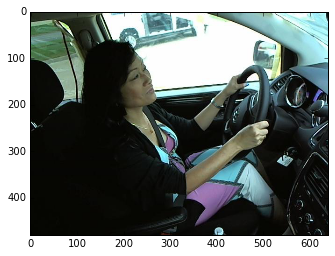

In [8]:
import matplotlib.image as mpimg
img=mpimg.imread(df.filepath.iloc[0])
imgplot = plt.imshow(img)

** Read the first image from LMDB to verify that it is the same **

In [12]:
import lmdb

In [13]:
from caffe.proto import caffe_pb2
lmdb_file = "/home/ubuntu/distracteddriver/test_db/"
lmdb_env = lmdb.open(lmdb_file)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe_pb2.Datum()

label  caffe.Datum


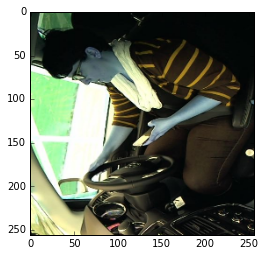

In [20]:
for key, value in lmdb_cursor:
    datum.ParseFromString(value)

#    label = datum.
    data = caffe.io.datum_to_array(datum)
    im = data.astype(np.uint8)
    im = np.transpose(im, (2, 1, 0)) # original (dim, col, row)
    print "label ", label

    plt.imshow(im)
    plt.show()
    break

** Oh oh! these images are different. Probably because lmdb does not store files in order. To explore later if lmdb stores file names in the database **